In [2]:
# importing packages and modules
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import minimize
from utils import *
from plotting_utils import *
from analysis_utils import *
import dglm_hmm1
from scipy.stats import multivariate_normal, norm
import jax

In [3]:
# setting hyperparameters
S = 10 # sessions
T = 500 # trials per session
N = T * S # total data points
C = 2 # classes
K = 2 # states
D = 2 # features (sensory & bias)

In [4]:
# True Transition Matrix
trueP = np.zeros((2,2))
trueP[0,0]=0.97
trueP[0,1]=0.03
trueP[1,0]=.05
trueP[1,1]=.95
print("True Transition Matrix P")
print(trueP)

True Transition Matrix P
[[0.97 0.03]
 [0.05 0.95]]


Session indicies
[0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]
(5000, 2, 2, 2)


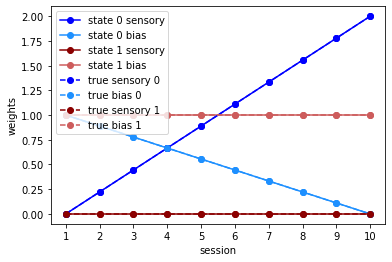

In [5]:
# True Weights and Session Start Indices
ourW = np.zeros((S,K,D))
ourW[:,0,1] = np.linspace(0,2,S) # state 1 sensory (increasing)
ourW[:,0,0] = np.linspace(1,0,S) # state 1 bias (decreasing)
ourW[:,1,1] = 0 # state 2 sensory (flat 0)
ourW[:,1,0] = 1 # state 2 bias (flat 1)
trueW = np.zeros((N,K,D,C))
# change weight format to have session*trials points
sessInd = []
for sess in range(0,S):
    sessInd.append(sess*T)
    for t in range(0,T):
        trueW[sess*T+t,:,:,0] = ourW[sess,:,:]
sessInd.append(N)
print("Session indicies")
print(sessInd)

testSessInd = []
for sess in range(0,S+1):
    testSessInd.append(sess*1000)

print(trueW.shape)
plotting_weights(trueW, sessInd, trueW)

In [6]:
dGLM_HMM = dglm_hmm1.dGLM_HMM1(N,K,D,C)

# _, _, _= dGLM_HMM.simulate_data(trueW, trueP, sessInd, save=True, title=f'../data/N={N}_{K}_state_constant-drift_train')
#_, _, _= dGLM_HMM.simulate_data(trueW, trueP, sessInd, save=True, title=f'../data/{K}_state_constant-drift_test') # test has size N=1000*10
trainX = np.load(f'../data/N={N}_{K}_state_constant-drift_trainX.npy')
trainY = np.load(f'../data/N={N}_{K}_state_constant-drift_trainY.npy')

In [8]:
ourSigma = np.zeros((2,2)) # k x d
ourSigma[0,0] = 0.11
ourSigma[0,1] = 0.22
ourSigma[1,0] = 0.01
ourSigma[1,1] = 0.01

initP, initW = dGLM_HMM.generate_param(sessInd=sessInd, transitionDistribution=['dirichlet', (5, 1)], weightDistribution=['uniform', (-2,2)]) # initialize the model parameters
checkP, checkW, checkLl = dGLM_HMM.fit(trainX, trainY,  initP, initW, sigma=ourSigma, sessInd=sessInd, pi0=None, maxIter=300, tol=1e-4) # fit the model
print(np.argmax(checkLl))

299


In [15]:
testX = np.load(f'../data/{K}_state_constant-drift_testX.npy')
testY = np.load(f'../data/{K}_state_constant-drift_testY.npy')
testPhi = dGLM_HMM.observation_probability(testX, reshapeWeights(checkW[0], sessInd, testSessInd))
# _, _, testLl = dGLM_HMM.forward_pass(testY,checkP[0],testPhi)
# print("test LL per trial=", testLl/N/2)

#plotting_weights(checkW, sessInd, trueW, 'recovered weights sigma=0.1')

In [7]:
ourSigma = np.zeros((2,2)) # k x d
ourSigma[0,0] = 0.11
ourSigma[0,1] = 0.22
ourSigma[1,0] = 0.01
ourSigma[1,1] = 0.01
inits = 20
checkP = np.empty((inits,K,K))
checkW = np.empty((inits,trainX.shape[0],K,D,C))
checkLl = np.empty((inits, 300))
for init in range(0,inits):
    initP, initW = dGLM_HMM.generate_param(sessInd=sessInd, transitionDistribution=['dirichlet', (5, 1)], weightDistribution=['uniform', (-2,2)]) # initialize the model parameters
    checkP[init], checkW[init], checkLl[init] = dGLM_HMM.fit(trainX, trainY,  initP, initW, sigma=ourSigma, sessInd=sessInd, pi0=None, maxIter=300, tol=1e-4) # fit the model
    print(np.argmax(checkLl))

np.save('../data/P_2_state_ourSigma', checkP)
np.save('../data/trainLl_2_state_ourSigma', checkLl)
np.save('../data/W_2_state_ourSigma', checkW)

5180
5180
5180
5180
5180
5180
5180
5180
5180
5180
5180
5180
5180
5180
5180
5180
5180


KeyboardInterrupt: 

In [21]:
ourSigma = np.zeros((2,2)) # k x d
ourSigma[0,0] = 0.11
ourSigma[0,1] = 0.22
ourSigma[1,0] = 0.01
ourSigma[1,1] = 0.01
print(ourSigma)

[[0.11 0.22]
 [0.01 0.01]]


test LL per trial= -0.5955408777353932
299


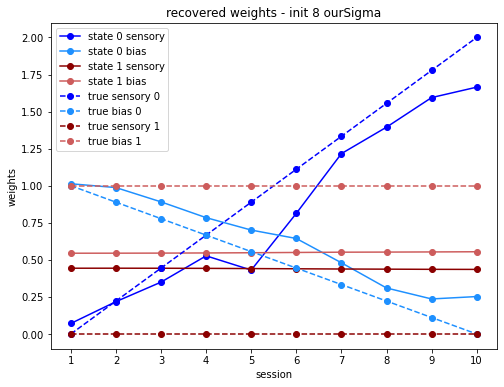

test LL per trial= -0.5900529883350307
299


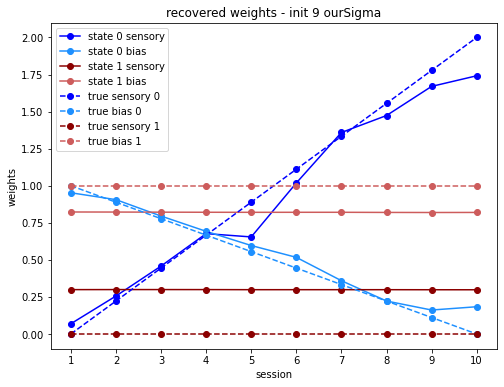

test LL per trial= -0.5901541637726203
299


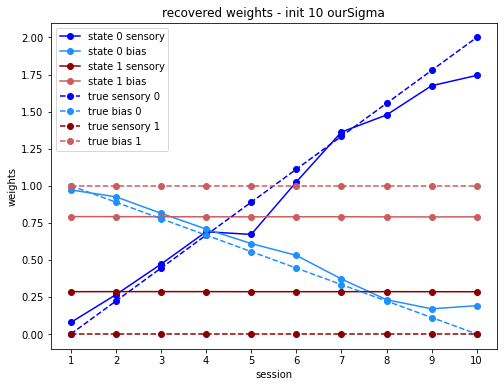

test LL per trial= -0.591586768841785
299


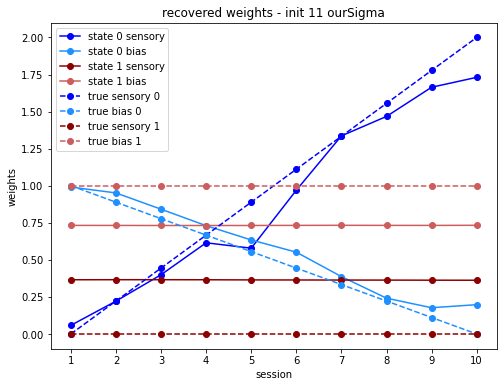

test LL per trial= -0.5922191940984899
299


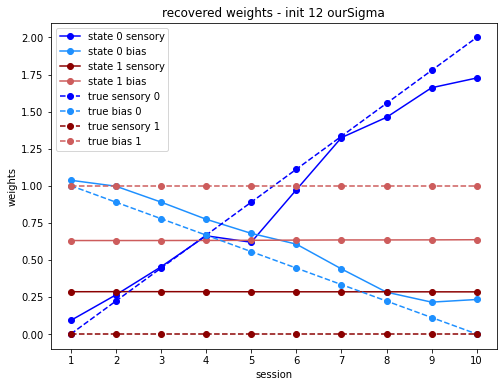

In [20]:
checkP = np.load('../data/P_2_state_ourSigma.npy')
checkLl = np.load('../data/trainLl_2_state_ourSigma.npy')
checkW = np.load('../data/W_2_state_ourSigma.npy')

for init in range(8,13):
    testPhi = dGLM_HMM.observation_probability(testX, reshapeWeights(checkW[init], sessInd, testSessInd))
    _, _, testLl = dGLM_HMM.forward_pass(testY,checkP[init],testPhi)
    print("test LL per trial=", testLl/N/2)
    print(np.argmax(checkLl[init]))
    plt.figure(figsize=(8,6))
    plotting_weights(permute_states(checkW[init], sessInd), sessInd, trueW, f'recovered weights - init {init} ourSigma')

In [16]:
#Fitting for multiple values of Sigma 
sigmaList = [0.008,0.04,0.09,0.2,0.45,1,2.23,5,11.18,25,125]
allLl, allP, allW = fit_multiple_sigmas(N=N,K=K,D=D,C=C, sessInd=sessInd, sigmaList=sigmaList, inits=5, maxiter=300, modelType='constant-drift', save=True)

0
0
1
1
2
2
3
3
4
4
5
5
6
6
7
7
8
8
9
9
10
10
0
0
1
1
2
2
3
3
4
4
5
5
6
6
7
7
8
8
9
9
10
10
0
0
1
1
2
2
3
3
4
4
5
5
6
6
7
7
8
8
9
9
10
10
0
0
1
1
2
2
3
3
4
4
5
5
6
6
7
7
8
8
9
9
10
10
0
0
1
1
2
2
3
3
4
4
5
5
6
6
7
7
8
8
9
9
10
10


[[0.9529724  0.0470276 ]
 [0.03318204 0.96681796]]


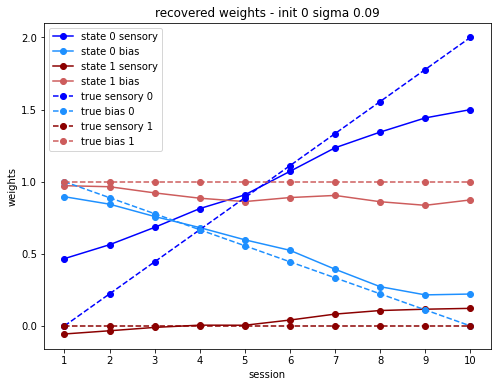

[[0.95400774 0.04599226]
 [0.03446625 0.96553375]]


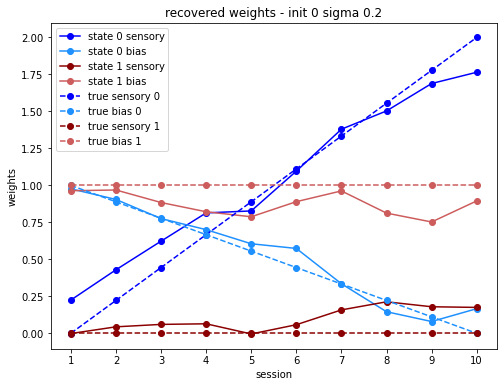

[[0.9851739  0.0148261 ]
 [0.03382107 0.96617893]]


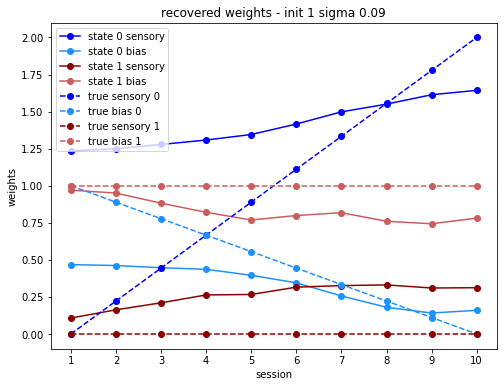

[[0.95635349 0.04364651]
 [0.03360805 0.96639195]]


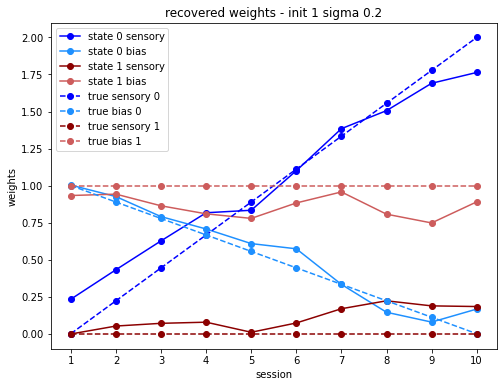

[[0.95336161 0.04663839]
 [0.0332781  0.9667219 ]]


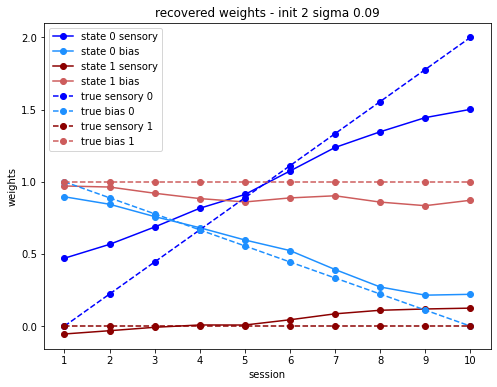

[[0.95406747 0.04593253]
 [0.03445458 0.96554542]]


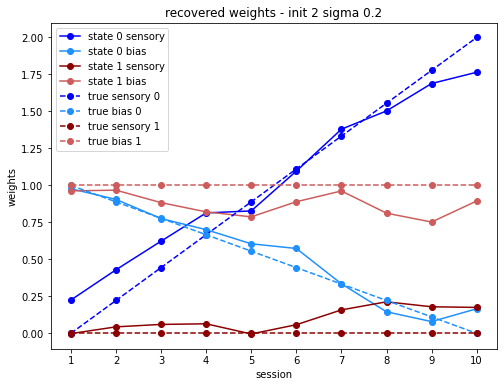

[[0.96680811 0.03319189]
 [0.04695683 0.95304317]]


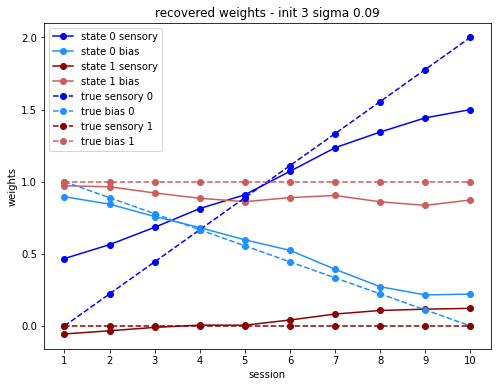

[[0.96553713 0.03446287]
 [0.04598015 0.95401985]]


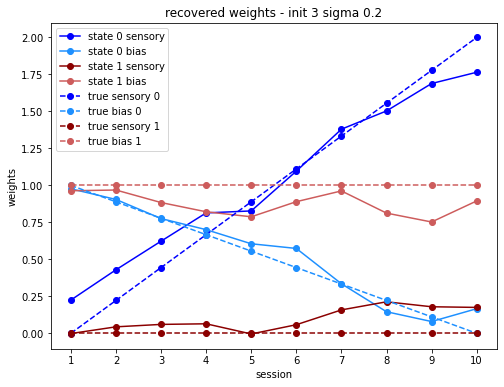

[[0.96678875 0.03321125]
 [0.04695835 0.95304165]]


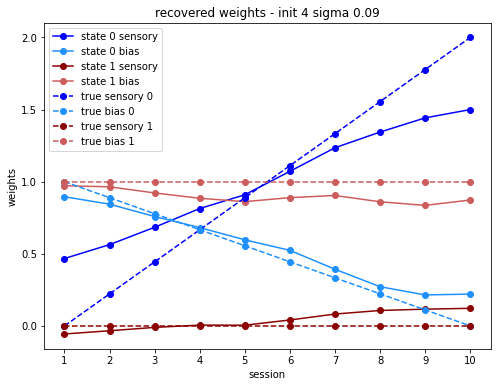

[[0.96553377 0.03446623]
 [0.04598301 0.95401699]]


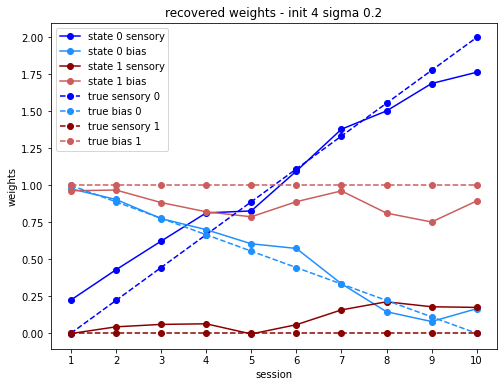

In [13]:
sigmaList = [0.008,0.04,0.09,0.2,0.45,1,2.23,5,11.18,25,125]
allW = np.load('../data//W_N=5000_2_state_constant-drift.npy')
allP = np.load('../data//P_N=5000_2_state_constant-drift.npy')
for init in range(0,5):
    for indSigma in range(2,4): 
        #print(np.argmax(allLl[init,indSigma]))
        print(allP[init,indSigma])
        plt.figure(figsize=(8,6))
        plotting_weights(permute_states(allW[init, indSigma],sessInd), sessInd, trueW, f'recovered weights - init {init} sigma {sigmaList[indSigma]}')

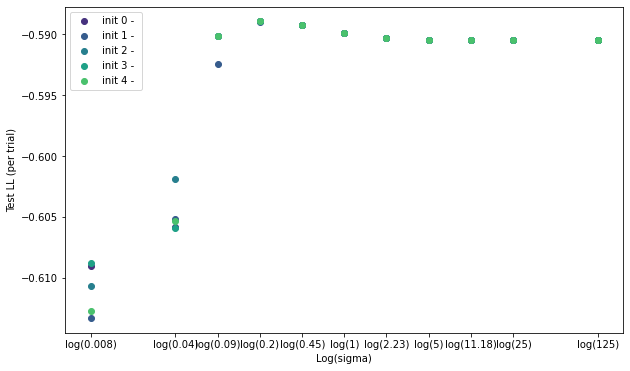

In [18]:
testLl = evaluate_multiple_sigmas(N,K,D,C, trainSessInd=sessInd, testSessInd=testSessInd, sigmaList=[0.008,0.04,0.09,0.2,0.45,1,2.23,5,11.18,25,125], modelType='constant-drift', save=True)
    
sigmaList = [0.008,0.04,0.09,0.2,0.45,1,2.23,5,11.18,25,125]
fig, axes = plt.subplots(1, figsize = (10,6))
sigma_testLl_plot(sigmaList=sigmaList, testLl=testLl, axes=axes, title='', label='', save_fig=False)